<a href="https://colab.research.google.com/github/MagicMoleMM/Machine_learning_LSTM/blob/main/LSTM_EURUSD_Daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch



## Download Dataset

In [2]:
import requests
import csv
import seaborn as sns

## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

Функция получения данных AV

In [4]:
def get_fx_daily(from_symbol, to_symbol, outputsize, apikey):

    url = f'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={from_symbol}&to_symbol={to_symbol}&outputsize={outputsize}&datatype=csv&apikey={apikey}'

    r = requests.get(url)
    decoded_content = r.content.decode('utf-8')
    data = csv.reader(decoded_content.splitlines(), delimiter=',')
    dt = pd.DataFrame(data)
    dt.columns = ['timestamp','open', 'high', 'low', 'close']
    dt = dt.iloc[1:]
    dt = dt.set_index('timestamp', inplace=False)

    return dt

Получение данных AV

In [45]:
from_symbol = 'USD'
to_symbol = 'RUB'
interval = '60min'  # 1min, 5min, 15min, 30min, 60min
outputsize = 'full'  # Optional compact or full
apikey = '2GGORTBXQIFSR2AF'

#  Загружаем данные


data_1d_load = get_fx_daily(from_symbol, to_symbol, outputsize, apikey).iloc[::-1]

Загрузка в формате csv


In [46]:
data_1d_load.to_csv(f'{from_symbol}{to_symbol}_1d.csv')

In [47]:
print(data_1d_load)

                open      high       low     close
timestamp                                         
2014-11-24  45.69910  45.84200  44.34780  44.94000
2014-11-25  44.94000  46.34500  44.59670  46.31390
2014-11-26  46.30000  47.42130  46.01750  47.39360
2014-11-27  47.39500  49.27400  46.68890  49.09690
2014-11-28  48.63850  50.68550  48.61600  50.47380
...              ...       ...       ...       ...
2022-07-11  64.89550  64.90740  60.98500  64.25000
2022-07-12  64.25000  64.25000  57.50000  58.41650
2022-07-13  58.41270  61.00000  57.62500  58.46060
2022-07-14  58.46700  60.25000  57.77500  59.20500
2022-07-15  58.26770  59.70000  55.62500  55.75000

[1995 rows x 4 columns]



DataFrame

In [48]:
training_set_1 = pd.DataFrame(data_1d_load)
training_set_1

,open,high,low,close
timestamp,,,,
2014-11-24,45.69910,45.84200,44.34780,44.94000
2014-11-25,44.94000,46.34500,44.59670,46.31390
2014-11-26,46.30000,47.42130,46.01750,47.39360
2014-11-27,47.39500,49.27400,46.68890,49.09690
2014-11-28,48.63850,50.68550,48.61600,50.47380
...,...,...,...,...
2022-07-11,64.89550,64.90740,60.98500,64.25000
2022-07-12,64.25000,64.25000,57.50000,58.41650
2022-07-13,58.41270,61.00000,57.62500,58.46060


 Цены закрытия

In [49]:
price_close = training_set_1.close
pd.to_datetime(price_close.index)
pd.to_numeric(price_close.values)
price_close

timestamp
2014-11-24    44.94000
2014-11-25    46.31390
2014-11-26    47.39360
2014-11-27    49.09690
2014-11-28    50.47380
                ...   
2022-07-11    64.25000
2022-07-12    58.41650
2022-07-13    58.46060
2022-07-14    59.20500
2022-07-15    55.75000
Name: close, Length: 1995, dtype: object

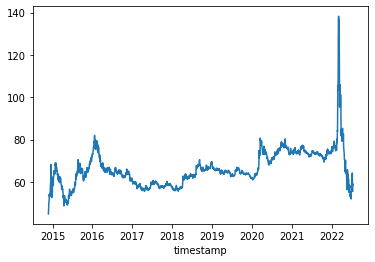

In [50]:
training_set = price_close
#training_set = pd.read_csv('shampoo.csv')

# training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
# plt.plot(price_close.index, price_close.values)
# plt.show()

g=sns.lineplot(y=pd.to_numeric(training_set.values), x=pd.to_datetime(training_set.index), data=training_set)


In [51]:
print(training_set)
print(len(training_set))

timestamp
2014-11-24    44.94000
2014-11-25    46.31390
2014-11-26    47.39360
2014-11-27    49.09690
2014-11-28    50.47380
                ...   
2022-07-11    64.25000
2022-07-12    58.41650
2022-07-13    58.46060
2022-07-14    59.20500
2022-07-15    55.75000
Name: close, Length: 1995, dtype: object
1995


## Dataloading

In [52]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_ = np.array(training_set[:1800]).reshape(-1, 1)
training_data = sc.fit_transform(training_)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

trainX = Variable(torch.Tensor(np.array(x)))
trainY = Variable(torch.Tensor(np.array(y)))

# trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
# trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
# testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


data_set = np.array(training_set[1800:]).reshape(-1, 1)
data_data = sc.transform(data_set)

seq_length = 4
a, b = sliding_windows(data_data, seq_length)

dataX = Variable(torch.Tensor(np.array(a)))
dataY = Variable(torch.Tensor(np.array(b)))


In [54]:
print(len(training_set[1800:]))
print(len(training_))


195
1800


## Model

In [55]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [56]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 10
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.40873
Epoch: 100, loss: 0.00093
Epoch: 200, loss: 0.00068
Epoch: 300, loss: 0.00065
Epoch: 400, loss: 0.00063
Epoch: 500, loss: 0.00060
Epoch: 600, loss: 0.00057
Epoch: 700, loss: 0.00054
Epoch: 800, loss: 0.00051
Epoch: 900, loss: 0.00049
Epoch: 1000, loss: 0.00047
Epoch: 1100, loss: 0.00047
Epoch: 1200, loss: 0.00046
Epoch: 1300, loss: 0.00046
Epoch: 1400, loss: 0.00046
Epoch: 1500, loss: 0.00046
Epoch: 1600, loss: 0.00046
Epoch: 1700, loss: 0.00046
Epoch: 1800, loss: 0.00046
Epoch: 1900, loss: 0.00046


## Testing 

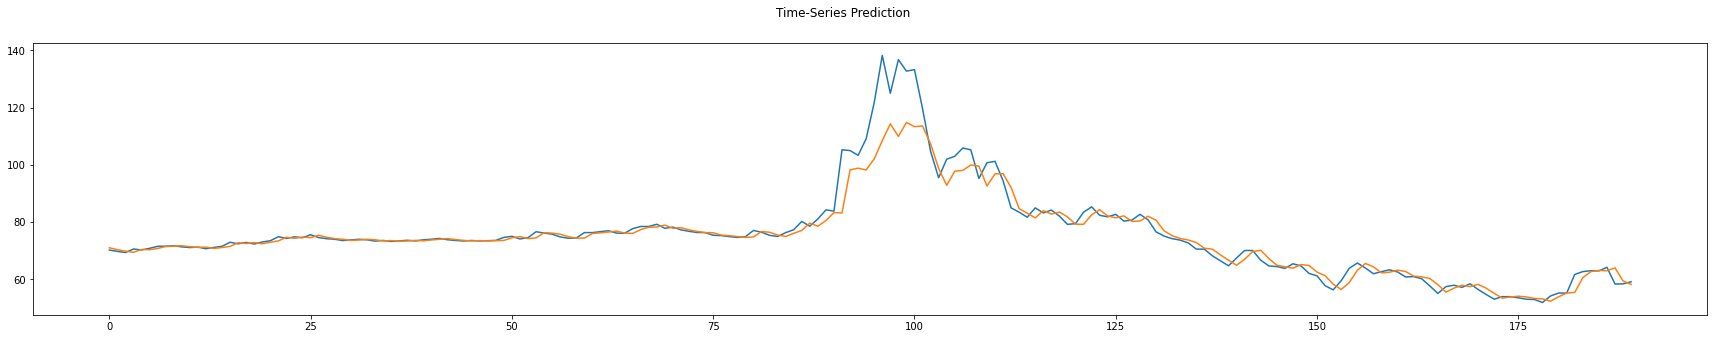

In [59]:
lstm.eval()
# train_predict = lstm(trainX)
train_predict_test = lstm(dataX)

# data_predict1 = train_predict.data.numpy()
data_predict1_test = train_predict_test.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict1)
data_predict_test = sc.inverse_transform(data_predict1_test)
dataY_plot = sc.inverse_transform(dataY_plot)

# plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(30, 5))
plt.plot(dataY_plot)
# plt.plot(data_predict)
plt.plot(data_predict_test)
plt.suptitle('Time-Series Prediction')
plt.show()

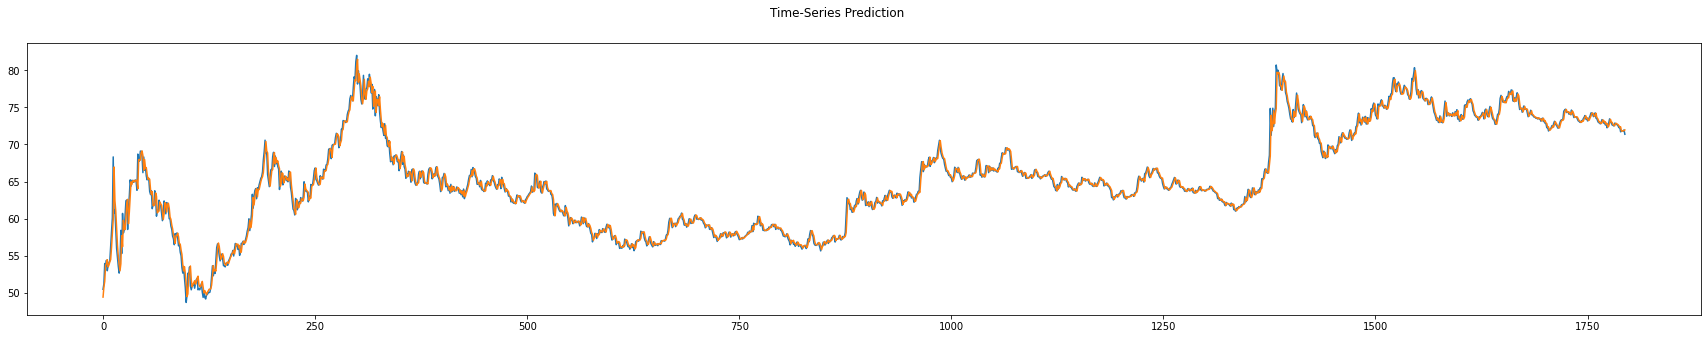

In [58]:
lstm.eval()
train_predict = lstm(trainX)
# train_predict_test = lstm(dataX)

data_predict1 = train_predict.data.numpy()
# data_predict1_test = train_predict_test.data.numpy()
trainY_plot = trainY.data.numpy()

data_predict = sc.inverse_transform(data_predict1)
# data_predict_test = sc.inverse_transform(data_predict1_test)
trainY_plot = sc.inverse_transform(trainY_plot)

# plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(30, 5))
plt.plot(trainY_plot)
# plt.plot(data_predict)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()


